<a href="https://colab.research.google.com/github/shatinz/tripreports/blob/master/schemasearchforembedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# initialing

In [ ]:
from google.colab import output
!git config --global user.email shatincia@gmail.com
!git config --global user.name GH_TOKEN

# Install GitHub CLI (optional, but easier)
!apt-get install gh -y

In [3]:
!git clone https://github.com/shatinz/tripreports.git

Cloning into 'tripreports'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 73 (delta 30), reused 21 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 2.26 MiB | 3.33 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [6]:
%cd tripreports
!ls

/content/tripreports
 cleaned_reports.json			        requirements.txt
 config.py				        schemasearchforembedding.ipynb
 gemini.py				        tripreport
 __pycache__				        tripreport2.ipynb
'report_embeddings (1).json'		        tripreport2.py
 report_embeddings_with_hdbscan_clusters.json   tripreport.ipynb
 report_prototype_similarity.json


In [4]:
schema_fields = [
    "having_previous_experience",
    "vegan_regieme" ,
    "having_sitter" ,
    "challenging_and_hard_trip" ,
    "experiencing_fear" ,
    "feeling_like_being_god" ,
    "proper_set_and_setting",
    "lifechanging_experience",
    "having_intention",
    "smooth_onset",
    "perceived_realness",
    "entities_or_other_beings",
    "childhood_trauma",
    "sex_effects",
    "self_love_experience",
]

In [9]:
import json

file_path = '/content/report_embeddings_gemma.json'

with open(file_path, 'r') as f:
    report_data = json.load(f)

# Assuming the JSON structure has keys that match the desired schema_fields
# and the first dictionary in the list contains these keys.
if report_data and isinstance(report_data, list) and isinstance(report_data[0], dict):
    extracted_fields = list(report_data[0].keys())
    print("Extracted fields from the JSON file:")
    print(extracted_fields)
else:
    extracted_fields = []
    print("Could not extract fields from the JSON data.")

Extracted fields from the JSON file:
['link', 'embedding_gemma']


In [8]:
!pip install -U sentence-transformers git+https://github.com/huggingface/transformers@v4.56.0-Embedding-Gemma-preview


  Cloning https://github.com/huggingface/transformers (to revision v4.56.0-Embedding-Gemma-preview) to /tmp/pip-req-build-9e6kkzi1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-9e6kkzi1
  Running command git checkout -q 60b68e304cf4b6569b0660a13b558b929d4b0e77
  Resolved https://github.com/huggingface/transformers to commit 60b68e304cf4b6569b0660a13b558b929d4b0e77
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.57.0.dev0-py3-none-any.whl size=12604658 sha256=12b99d1fc8a9953e464ab311ce6326727b1caf796a747d4f63acb1a55d168d45
  Stored in directory: /tmp/pip-ephem-wheel-cache-fsau8r43/wheels/3a/21/76/c31899bac2cf601d3c74091b26a413bc3fb54770d5ccb5c924
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.0
    Uni

In [10]:
from huggingface_hub import login
login()  # Follow prompt to input your Hugging Face token


## finding similarity between fields and reports

In [ ]:
import json
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load cleaned reports
try:
    with open('report_embeddings_gemma.json', 'r') as f:
        report_embeddings_gemma = json.load(f)
except FileNotFoundError:
    print("Error: 'report_embeddings_gemma.json' not found. Please make sure you have run the report embedding step.")
    report_embeddings_gemma = []

# Initialize the Gemma embedding model
gemma_model_name = 'google/embeddinggemma-300M'

try:
    embedding_model_gemma = SentenceTransformer(gemma_model_name)
except Exception as e:
    print(f"Could not load SentenceTransformer model '{gemma_model_name}'. Error: {e}")
    print("Falling back to 'sentence-transformers/all-MiniLM-L6-v2'.")
    gemma_model_name = 'sentence-transformers/all-MiniLM-L6-v2'
    embedding_model_gemma = SentenceTransformer(gemma_model_name)


print(f"Initialized embedding model: {gemma_model_name}")

# Embed the schema fields
schema_field_embeddings = embedding_model_gemma.encode(schema_fields)
print(f"Generated embeddings for {len(schema_fields)} schema fields.")

# Convert report embeddings from list to numpy array for efficient calculation
if report_embeddings_gemma:
    report_embeddings_array = np.array([item['embedding_gemma'] for item in report_embeddings_gemma if 'embedding_gemma' in item and isinstance(item['embedding_gemma'], list)])
    report_links = [item['link'] for item in report_embeddings_gemma if 'embedding_gemma' in item and isinstance(item['embedding_gemma'], list)]

    if report_embeddings_array.shape[0] > 0:
        print(f"Calculating cosine similarity between schema fields and {report_embeddings_array.shape[0]} report embeddings...")

        # Calculate cosine similarity
        # schema_field_embeddings shape: (num_schema_fields, embedding_dim)
        # report_embeddings_array shape: (num_reports, embedding_dim)
        # similarity_matrix shape: (num_schema_fields, num_reports)
        similarity_matrix = cosine_similarity(schema_field_embeddings, report_embeddings_array)

        # Find the most similar reports for each schema field
        most_similar_reports = {}
        for i, field in enumerate(schema_fields):
            # Get similarity scores for the current schema field
            field_similarity_scores = similarity_matrix[i]

            # Get the indices of the top N most similar reports (e.g., top 5)
            top_n_indices = np.argsort(field_similarity_scores)[::-1][:5] # Top 5 most similar

            # Store the links and similarity scores for the top reports
            top_reports_for_field = []
            for index in top_n_indices:
                top_reports_for_field.append({
                    'link': report_links[index],
                    'similarity_score': field_similarity_scores[index]
                })
            most_similar_reports[field] = top_reports_for_field

        # Print the most similar reports for each schema field
        print("\nMost similar reports for each schema field:")
        for field, reports in most_similar_reports.items():
            print(f"\nSchema Field: '{field}'")
            for report in reports:
                print(f"  - Link: {report['link']}, Similarity Score: {report['similarity_score']:.4f}")
    else:
        print("No valid report embeddings found to perform similarity calculation.")
else:
    print("No report embeddings loaded.")

# schema prototype
schema prototype and embedding *it*

In [ ]:
schema_prototypes = {
    "having_previous_experience": [
        "I had used psychedelics before this trip.",
        "This was not my first psychedelic experience."
    ],
    "vegan_regieme": [
        "I became vegan after this experience.",
        "This trip convinced me to stop eating meat."
    ],
    "having_sitter": [
        "My friend was watching me during the trip.",
        "Someone stayed with me to make sure I was safe."
    ],
    "challenging_and_hard_trip": [
        "This was a very difficult and overwhelming trip.",
        "I struggled a lot during the experience."
    ],
    "experiencing_fear": [
        "At some point, I was terrified.",
        "I thought I was dying."
    ],
    "feeling_like_being_god": [
        "I felt like I became god.",
        "I was the universe itself."
    ],
    "proper_set_and_setting": [
        "The environment was comfortable and safe.",
        "I carefully prepared the setting for the trip."
    ],
    "lifechanging_experience": [
        "This experience completely changed my life.",
        "I made huge decisions after this trip."
    ],
    "having_intention": [
        "I had a clear intention before the trip.",
        "My goal was to heal through this journey."
    ],
    "smooth_onset": [
        "The onset was gentle and smooth.",
        "The beginning was very gradual."
    ],
    "perceived_realness": [
        "It felt more real than reality.",
        "The visions were completely real to me."
    ],
    "entities_or_other_beings": [
        "I encountered other beings.",
        "I spoke with entities during the trip."
    ],
    "childhood_trauma": [
        "Memories of childhood trauma surfaced.",
        "I faced painful childhood experiences."
    ],
    "sex_effects": [
        "The trip influenced my sexual experiences.",
        "I felt changes in sexual energy."
    ],
    "self_love_experience": [
        "I felt deep love for myself.",
        "I embraced myself fully for the first time."
    ],
    "meditation": [
        "I started meditating during the trip.",
        "The experience felt like a deep meditation."
    ],
    "ceremonical": [
        "This trip took place in a shamanic ceremony.",
        "The experience was part of a sacred ritual."
    ],
}


In [ ]:
# Embed the schema prototypes
schema_prototype_embeddings = {}
for field, prototypes in schema_prototypes.items():
    # Encode each prototype sentence for the current field
    prototype_embeddings = embedding_model_gemma.encode(prototypes)
    schema_prototype_embeddings[field] = prototype_embeddings

print(f"Generated embeddings for schema prototypes.")

Generated embeddings for schema prototypes.


In [ ]:
# Calculate similarity between schema prototypes and each report and save the results
report_prototype_similarity = []

if report_embeddings_gemma and report_embeddings_array.shape[0] > 0:
    print("Calculating similarity between schema prototypes and each report...")

    for i, report_embedding in enumerate(report_embeddings_array):
        report_link = report_links[i]
        report_similarity_scores = {}

        for field, prototype_embeddings in schema_prototype_embeddings.items():
            # Calculate cosine similarity between the report embedding and each prototype embedding for the field
            # report_embedding shape: (embedding_dim,)
            # prototype_embeddings shape: (num_prototypes, embedding_dim)
            # similarity_scores shape: (num_prototypes,)
            similarity_scores = cosine_similarity([report_embedding], prototype_embeddings)[0]

            # You can choose to store the average similarity, the maximum similarity, or individual scores
            # For now, let's store the maximum similarity score for each field
            report_similarity_scores[field] = float(np.max(similarity_scores)) # Convert to float for JSON serialization

        report_prototype_similarity.append({
            'link': report_link,
            'prototype_similarity': report_similarity_scores
        })

    # Save the results to a JSON file
    output_file_path = 'report_prototype_similarity.json'
    with open(output_file_path, 'w') as f:
        json.dump(report_prototype_similarity, f, indent=4)

    print(f"Similarity results saved to '{output_file_path}'.")

else:
    print("No valid report embeddings found to calculate similarity.")

Calculating similarity between schema prototypes and each report...
Similarity results saved to 'report_prototype_similarity.json'.


# clustering


## hdbclustering - kmeans

### Subtask:
Load the trip report data that you want to use for topic modeling.


In [ ]:
from hdbscan import HDBSCAN

# Apply HDBSCAN clustering
if similarity_matrix.shape[0] > 0:
    print("Applying HDBSCAN clustering...")
    # Initialize HDBSCAN model. You can adjust parameters like min_cluster_size, min_samples, etc.
    hdbscan = HDBSCAN(min_cluster_size=5, gen_min_span_tree=True) # Example parameters
    report_clusters_hdbscan = hdbscan.fit_predict(similarity_matrix)

    print("HDBSCAN clustering applied successfully.")
    print(f"Number of clusters found (excluding noise): {len(set(report_clusters_hdbscan)) - (1 if -1 in report_clusters_hdbscan else 0)}")
    print(f"Reports assigned to noise (-1): {np.sum(report_clusters_hdbscan == -1)}")

    # You can now analyze the 'report_clusters_hdbscan' array
else:
    print("No data available for HDBSCAN clustering.")

Applying HDBSCAN clustering...
HDBSCAN clustering applied successfully.
Number of clusters found (excluding noise): 0
Reports assigned to noise (-1): 99


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score

# Apply KMeans clustering
n_clusters = 5  # You can change the number of clusters
if similarity_matrix.shape[0] > 0:
    print(f"Applying KMeans clustering with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    report_clusters_kmeans = kmeans.fit_predict(similarity_matrix)

    print("KMeans clustering applied successfully.")
    # The 'report_clusters_kmeans' array contains the cluster label for each report.
    # You can now analyze these clusters.

    # Example: Count reports in each cluster
    unique_clusters, counts = np.unique(report_clusters_kmeans, return_counts=True)
    print("\nReport counts per cluster:")
    for cluster_label, count in zip(unique_clusters, counts):
        print(f"Cluster {cluster_label}: {count} reports")

    # Evaluate clustering results
    print(f"\nInertia (within-cluster sum of squares): {kmeans.inertia_:.4f}")

    # Calculate Silhouette Score (requires at least 2 clusters and more than 1 sample)
    if n_clusters > 1 and similarity_matrix.shape[0] > 1:
        try:
            silhouette_avg = silhouette_score(similarity_matrix, report_clusters_kmeans)
            print(f"Silhouette Score: {silhouette_avg:.4f}")
        except Exception as e:
            print(f"Could not calculate Silhouette Score: {e}")

else:
    print("No data available for KMeans clustering.")

Applying KMeans clustering with 5 clusters...
KMeans clustering applied successfully.

Report counts per cluster:
Cluster 0: 30 reports
Cluster 1: 18 reports
Cluster 2: 26 reports
Cluster 3: 10 reports
Cluster 4: 15 reports

Inertia (within-cluster sum of squares): 0.9187
Silhouette Score: 0.1555


###

# finding relation between fields

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Load the report prototype similarity data if not already loaded
# Assuming report_prototype_similarity is available from previous steps,
# but adding a fallback to load from file if needed.
if 'report_prototype_similarity' not in locals() or not report_prototype_similarity:
    file_path = 'report_prototype_similarity.json'
    report_prototype_similarity = []
    try:
        with open(file_path, 'r') as f:
            report_prototype_similarity = json.load(f)
        print(f"Loaded similarity data from '{file_path}'.")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Cannot calculate correlation.")
        report_prototype_similarity = []
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{file_path}'. Cannot calculate correlation.")
        report_prototype_similarity = []


if report_prototype_similarity:
    # Convert the similarity data into a pandas DataFrame
    # Each row is a report, each column is a schema field, values are similarity scores
    similarity_scores_dict = {report['link']: report['prototype_similarity'] for report in report_prototype_similarity}
    similarity_df = pd.DataFrame.from_dict(similarity_scores_dict, orient='index')

    print("Calculating Spearman correlation matrix...")

    # Calculate Spearman correlation matrix
    # Handle potential NaNs or infinite values if they exist in similarity_df
    # Replace inf with NaN and then drop NaNs for correlation calculation
    similarity_df = similarity_df.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')


    if not similarity_df.empty and similarity_df.shape[0] > 1:
        spearman_corr_matrix = similarity_df.corr(method='spearman')

        print("\nSpearman Correlation Matrix:")
        display(spearman_corr_matrix)
    else:
        print("Not enough valid data to calculate Spearman correlation.")

else:
    print("No similarity data available to calculate correlation.")

Calculating Spearman correlation matrix...

Spearman Correlation Matrix:


,having_previous_experience,vegan_regieme,having_sitter,challenging_and_hard_trip,experiencing_fear,feeling_like_being_god,proper_set_and_setting,lifechanging_experience,having_intention,smooth_onset,perceived_realness,entities_or_other_beings,childhood_trauma,sex_effects,self_love_experience
having_previous_experience,1.000000,0.507755,0.634174,0.534051,0.421286,0.507953,0.416166,0.576129,0.561892,0.494236,0.591367,0.694583,0.464811,0.539728,0.418800
vegan_regieme,0.507755,1.000000,0.658108,0.688015,0.684378,0.683290,0.530761,0.860742,0.606308,0.426555,0.596871,0.558664,0.716524,0.679555,0.685529
having_sitter,0.634174,0.658108,1.000000,0.643018,0.499035,0.569153,0.720049,0.625059,0.720804,0.558417,0.579505,0.647866,0.492430,0.782350,0.530600
challenging_and_hard_trip,0.534051,0.688015,0.643018,1.000000,0.798899,0.423847,0.468002,0.656908,0.545739,0.286357,0.437798,0.517390,0.553878,0.522412,0.374038
experiencing_fear,0.421286,0.684378,0.499035,0.798899,1.000000,0.582721,0.331614,0.725603,0.400297,0.394249,0.585838,0.373210,0.699184,0.404465,0.549450
feeling_like_being_god,0.507953,0.683290,0.569153,0.423847,0.582721,1.000000,0.456413,0.761917,0.518899,0.543896,0.786160,0.646778,0.690699,0.464589,0.700124
proper_set_and_setting,0.416166,0.530761,0.720049,0.468002,0.331614,0.456413,1.000000,0.456116,0.807100,0.498751,0.391082,0.524403,0.366122,0.572035,0.405158
lifechanging_experience,0.576129,0.860742,0.625059,0.656908,0.725603,0.761917,0.456116,1.000000,0.521187,0.526308,0.689845,0.567062,0.782944,0.613012,0.774682
having_intention,0.561892,0.606308,0.720804,0.545739,0.400297,0.518899,0.807100,0.521187,1.000000,0.402696,0.511812,0.743537,0.450600,0.637563,0.518590
smooth_onset,0.494236,0.426555,0.558417,0.286357,0.394249,0.543896,0.498751,0.526308,0.402696,1.000000,0.574941,0.374001,0.489227,0.452344,0.567755


In [ ]:
# Analyze the Spearman correlation matrix to identify strong correlations
if 'spearman_corr_matrix' in locals() and not spearman_corr_matrix.empty:
    print("Analyzing the Spearman correlation matrix...")

    # Set the diagonal to NaN to exclude self-correlations
    analysis_matrix = spearman_corr_matrix.copy()
    np.fill_diagonal(analysis_matrix.values, np.nan)

    # Find the strongest positive correlations (excluding self-correlation)
    # Stack the matrix to easily sort by correlation value
    stacked_corr = analysis_matrix.unstack()
    # Drop NaN values (which include the diagonal and any original NaNs)
    stacked_corr = stacked_corr.dropna()
    # Sort in descending order to get strongest positive correlations first
    strongest_positive_correlations = stacked_corr.sort_values(ascending=False)

    print("\nTop 10 Strongest Positive Correlations:")
    if not strongest_positive_correlations.empty:
        display(strongest_positive_correlations.head(10))
    else:
        print("No positive correlations found (excluding self-correlation).")


    # Find the strongest negative correlations
    # Sort in ascending order to get strongest negative correlations first
    strongest_negative_correlations = stacked_corr.sort_values(ascending=True)

    print("\nTop 10 Strongest Negative Correlations:")
    if not strongest_negative_correlations.empty:
         # Display the top 10, ensuring we don't show the same pair twice (e.g., A-B and B-A)
        # A simple way is to just show the first 10 unique pairs based on sorted absolute value,
        # but for clarity, let's just show the top 10 negative values directly.
        display(strongest_negative_correlations.head(10))
    else:
        print("No negative correlations found.")

else:
    print("Spearman correlation matrix not available for analysis.")

Analyzing the Spearman correlation matrix...

Top 10 Strongest Positive Correlations:


,,0
vegan_regieme,lifechanging_experience,0.860742
lifechanging_experience,vegan_regieme,0.860742
proper_set_and_setting,having_intention,0.807100
having_intention,proper_set_and_setting,0.807100
experiencing_fear,challenging_and_hard_trip,0.798899
challenging_and_hard_trip,experiencing_fear,0.798899
perceived_realness,feeling_like_being_god,0.786160
feeling_like_being_god,perceived_realness,0.786160
childhood_trauma,lifechanging_experience,0.782944
lifechanging_experience,childhood_trauma,0.782944



Top 10 Strongest Negative Correlations:


,,0
challenging_and_hard_trip,smooth_onset,0.286357
smooth_onset,challenging_and_hard_trip,0.286357
proper_set_and_setting,experiencing_fear,0.331614
experiencing_fear,proper_set_and_setting,0.331614
childhood_trauma,proper_set_and_setting,0.366122
proper_set_and_setting,childhood_trauma,0.366122
experiencing_fear,entities_or_other_beings,0.373210
entities_or_other_beings,experiencing_fear,0.373210
smooth_onset,entities_or_other_beings,0.374001
entities_or_other_beings,smooth_onset,0.374001


Generating heatmap for the Spearman correlation matrix...


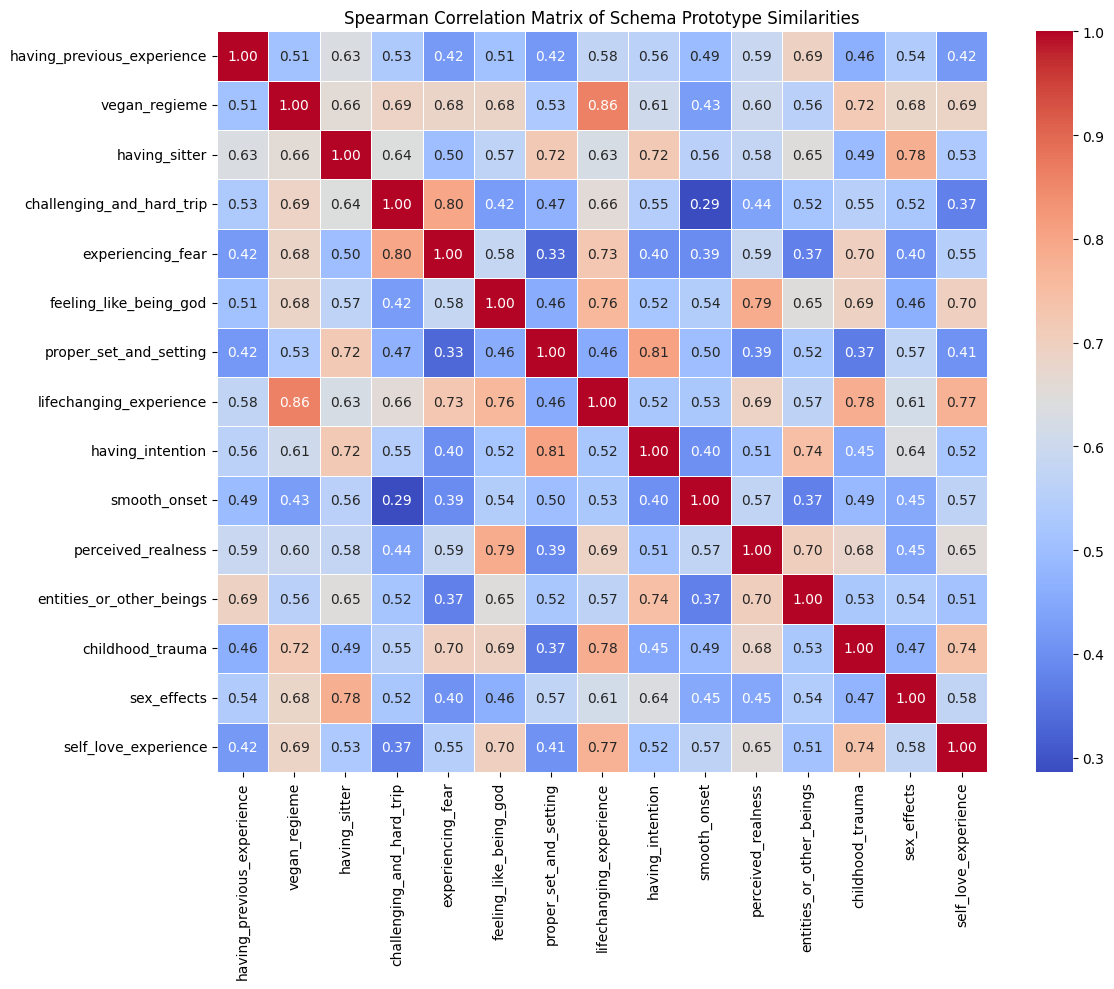

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the Spearman correlation matrix as a heatmap
if 'spearman_corr_matrix' in locals() and not spearman_corr_matrix.empty:
    print("Generating heatmap for the Spearman correlation matrix...")

    plt.figure(figsize=(12, 10))
    sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Spearman Correlation Matrix of Schema Prototype Similarities')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

else:
    print("Spearman correlation matrix not available for visualization.")